In [1]:
import os
import time
import librosa
import numpy as np
import tensorflow as tf
import cPickle as pickle
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
pickle_file = "../../my_features/US8K_mfcc40_meanstddelta.pickle"
with open(pickle_file, "rb") as f:
    dataset = pickle.load(f)
    X_train = dataset["X_train"]
    Y_train = dataset["Y_train"]
    X_valid = dataset["X_valid"]
    Y_valid = dataset["Y_valid"]
    X_test1 = dataset["X_test1"]
    Y_test1 = dataset["Y_test1"]
    X_test2 = dataset["X_test2"]
    Y_test2 = dataset["Y_test2"]
    del dataset

In [3]:
print ('training data: ' , X_train.shape, Y_train.shape)

print (Y_train[123])

('training data: ', (6234, 120), (6234, 10))
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


## 1. Tensorflow network

In [4]:
### 
N_FEATURES = X_train.shape[1]
N_LABELS = Y_train.shape[1]

In [5]:
## Place holder variables
X = tf.placeholder(tf.float32, [None, N_FEATURES])
Y = tf.placeholder(tf.float32, [None, N_LABELS])

## Helper function to create fully-connected layer
def new_fc_layer(in_layer, n_input_features, n_output_layer, activation=''):
    weights = tf.Variable(tf.truncated_normal([n_input_features, n_output_layer], stddev=0.1))
    biases = tf.Variable(tf.constant(value=1, dtype=tf.float32, shape = [n_output_layer]))
    out_layer = tf.matmul(in_layer, weights) + biases
    activation = activation.lower()
    if(activation == 'relu'):
        out_layer = tf.nn.relu(out_layer)
    elif(activation == 'tanh'):
        out_layer = tf.nn.tanh(out_layer)
    elif(activation == 'sigmoid'):
        out_layer = tf.nn.sigmoid(out_layer)
    return out_layer, weights, biases

In [6]:
## Hidden layer 1
N_HIDDEN_L1 = 100
hidden_layer_1, weight_1, biases_1 = new_fc_layer(X, N_FEATURES, N_HIDDEN_L1, 'relu')
## Hidden layer 2
N_HIDDEN_L2 = 64
hidden_layer_2, weight_2, biases_2 = new_fc_layer(hidden_layer_1, N_HIDDEN_L1, N_HIDDEN_L2, 'relu')

print (hidden_layer_1)
print (hidden_layer_2)

Tensor("Relu:0", shape=(?, 128), dtype=float32)
Tensor("Relu_1:0", shape=(?, 64), dtype=float32)


In [7]:
## Output layer
output_layer, weight_output, biases_output = new_fc_layer(hidden_layer_2, N_HIDDEN_L2, N_LABELS)
## Dropout
keep_prob = tf.placeholder(tf.float32)
output_layer_drop = tf.nn.dropout(output_layer, keep_prob=keep_prob)
print (output_layer_drop)
y_softmax = tf.nn.softmax(output_layer_drop)
print y_softmax

Tensor("dropout/mul:0", shape=(?, 10), dtype=float32)
Tensor("Softmax:0", shape=(?, 10), dtype=float32)


In [8]:
## Cost function and optimization
# BETA = 0.001 #L2 regularization penalty factor
LEARNING_RATE = 1e-3
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output_layer_drop, labels=Y)
cost = tf.reduce_mean(cross_entropy) # To be added L2 regularization
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

## Making Prediction
y_pred = tf.argmax(y_softmax, axis=1)
y_true = tf.argmax(Y, axis=1)

## 2. Tensorflow training session

In [9]:
classID = {
    0: "AirCon",
    1: "Car horn",
    2: "Children playing",
    3: "Dog bark",
    4: "Drilling",
    5: "Engine idling",
    6: "Gun shot",
    7: "Jackhammer",
    8: "Siren",
    9: "Street music"
}

BATCH_SIZE = 50
TRAINING_EPOCHS = 100

## Helper function for optimization
def optimize(train_x, train_y, n_epochs, batch_size, session):
        n_samples = train_x.shape[0]
        sample_IDs = np.arange(n_samples)
        n_iterations = np.int(np.floor(n_samples/batch_size))+1
        start_time = time.time()
        cost_history = np.empty(shape=[1],dtype=float)
        print "Training......."
        print "------ Elapsed time ------- Epoch ---- Cost "

        for epoch in np.arange(n_epochs+1):
            np.random.shuffle(sample_IDs)
            train_x_p, train_y_p = train_x[sample_IDs], train_y[sample_IDs]
            for itr in np.arange(n_iterations):
                start = (itr * batch_size) % (n_samples - batch_size)
                batch_x, batch_y = train_x_p[start:start + batch_size], train_y_p[start:start + batch_size]
                feed_dict_train = {X: batch_x, Y: batch_y, keep_prob: 1}
                _, c = session.run([optimizer, cost], feed_dict=feed_dict_train)
            if(epoch % (n_epochs/10) == 0):
                print "------ {:12.7f} ------- {:5d} ---- {:12.10f} ".format((time.time() - start_time), epoch, c)
            cost_history = np.append(cost_history,c)
        print ("---Running time: %s seconds ---" % (time.time() - start_time))
        print ('*'*50)
        fig = plt.figure(figsize=(10,5))
        plt.plot(cost_history)
        plt.axis([0,epoch,0,np.max(cost_history)])
        plt.show()

def output_log_file(session):
    file_name = pickle_file.split('/')[-1].split('.')[0]
    with open("log/logfile.txt", "ab") as text_file:
        text_file.write('='*60)
        text_file.write('\n')
        text_file.write("Time: {0}\n".format(datetime.now()))
        text_file.write("Data: " + file_name +"\n")    
        train_acc, train_f = make_prediction(X_train, Y_train, session)
        valid_acc, valid_f = make_prediction(X_valid, Y_valid, session)
        test1_acc, test1_f = make_prediction(X_test1, Y_test1, session)
        test2_acc, test2_f = make_prediction(X_test2, Y_test2, session)
        
#         text_file.write("Number of input samples: {:6d}\n".format(N_SA)
        text_file.write("Number of input features: {:4d}\n".format(N_FEATURES))
        text_file.write("Number of layer: 2\n")
        text_file.write("Hidden units: {:3d}  - {:3d}\n".format(N_HIDDEN_L1, N_HIDDEN_L2))
        text_file.write("Training epochs: {:5d}\n".format(TRAINING_EPOCHS))
        text_file.write("Batch size: {:3d}\n".format(BATCH_SIZE))
                        
        text_file.write('\tTrain\tValid\tTest1\tYoutube\n')
        text_file.write("Fscore\t {:1.2f} \t {:1.2f} \t {:1.2f} \t {:1.2f} \n".format(train_f, valid_f, test1_f, test2_f))
        text_file.write("Acc\t {:1.2f} \t {:1.2f} \t {:1.2f} \t {:1.2f} \n".format(train_acc, valid_acc, test1_acc, test2_acc))
        
        

## Helper function to print confusion matrix
def make_prediction(test_x, test_y, session):
    print "Making prediction......."
    start_time = time.time()
    feed_dict_test = {X: test_x, Y: test_y, keep_prob: 1}
    pred, true = session.run([y_pred, y_true], feed_dict=feed_dict_test)
## Performance Evaluation metrics
    ## Accuracy
    accuracy = accuracy_score(true, pred)
    print ("Accuracy: {:3.2f}".format(accuracy))
    ## F-score
    p,r,f,s = precision_recall_fscore_support(true, pred, average='macro')
    print ("F-Score: {:3.2f}".format(f))
    
    ## Confusion matrix
    print ("Confusion Matrix")
    print confusion_matrix(true, pred)
#     print ("Analyzing result")
#     for ID, name in classID.items():
#         x = pred[(true == ID)*(pred != ID)]  
#         unique_class, unique_count = np.unique(x, return_counts=True)
#         print ('-'*50)
#         print " Class {0} is mistaken with: ".format(name)
#         for c, y in zip(unique_class, unique_count):        
#             print "# {0}: {1} samples".format(classID[c], y)
#     print ('-'*50)
    print ("---Running time: {0} seconds ---".format((time.time() - start_time)))
    print ('*'*50)
    return accuracy, f
                    

Training.......
------ Elapsed time ------- Epoch ---- Cost 
------    0.2778630 -------     0 ---- 1.0772012472 
------    3.2498698 -------    10 ---- 0.1887571663 
------    6.2736819 -------    20 ---- 0.0944924578 
------    9.3232269 -------    30 ---- 0.1527838111 
------   12.3007698 -------    40 ---- 0.0585395806 
------   15.0136669 -------    50 ---- 0.1122375578 
------   17.9136250 -------    60 ---- 0.0529272221 
------   20.7021458 -------    70 ---- 0.0387437902 
------   23.5539620 -------    80 ---- 0.0020577905 
------   26.3474400 -------    90 ---- 0.0044541364 
------   29.0909638 -------   100 ---- 0.0066797580 
---Running time: 29.0911779404 seconds ---
**************************************************


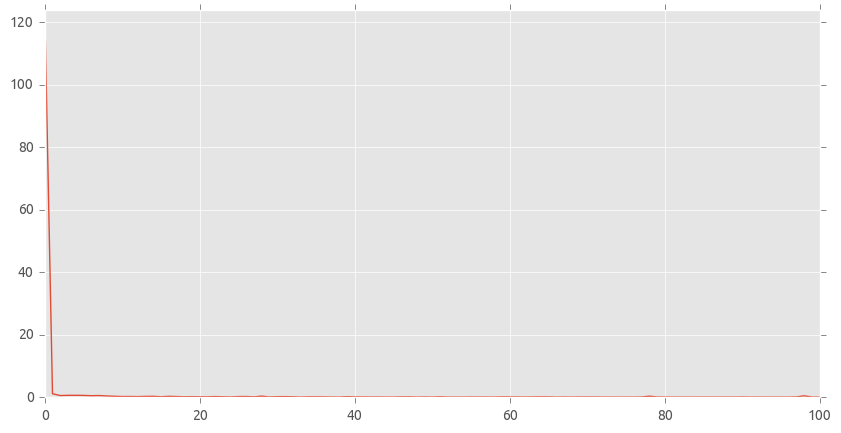

Making prediction.......
Accuracy: 1.00
F-Score: 1.00
Confusion Matrix
[[700   0   0   0   0   0   0   0   0   0]
 [  0 338   0   0   0   2   0   0   0   0]
 [  0   0 697   0   1   0   0   0   0   2]
 [  0   0   0 700   0   0   0   0   0   0]
 [  0   0   0   0 696   0   0   4   0   0]
 [  0   0   0   0   0 694   0   0   0   0]
 [  0   0   0   0   0   0 245   0   0   0]
 [  0   0   0   0   0   0   0 760   0   0]
 [  0   0   0   0   0   0   0   0 695   0]
 [  0   0   0   0   0   0   0   2   0 698]]
---Running time: 0.0250568389893 seconds ---
**************************************************
Making prediction.......
Accuracy: 0.59
F-Score: 0.60
Confusion Matrix
[[ 82   1  30   7  28  41   0   5   1   5]
 [  4  32   3   2   6   2   0   1   1   5]
 [ 11   0 133   3   3   5   0   0   2  43]
 [  0   1  13 157  11   0   1   0   1  16]
 [ 15   4   4   6 124   0   5  16  12  14]
 [ 23   2  12  20  14  93   0  21  17  11]
 [  0   0   0  12   2   1  82   0   0   0]
 [ 24   0   2   0  41   1   0 

/home/kyle/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [10]:


with tf.Session() as sess:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    optimize(X_train, Y_train, TRAINING_EPOCHS, BATCH_SIZE, sess)
    output_log_file(sess)
#     print ("Making prediction on training set")
#     make_prediction(X_train, Y_train, sess)
#     print ("Making prediction on validation set")
#     make_prediction(X_valid, Y_valid, sess)
#     print ("Making training prediction on test 1 set")
#     make_prediction(X_test1, Y_test1, sess)
#     print ("Making training prediction on test 2 set")
#     make_prediction(X_test2, Y_test2, sess)

    
    
    